# Point Cloud Clustering Milestone

This notebook captures the early-machine-learning milestone for the pointcloud-viewer project. It records the clustering model we plan to ship with the FastAPI backend so the Angular viewer can query pre-grouped point batches and highlight semantic regions inside large point clouds.


## Goal & Approach
The pointcloud viewer must present LiDAR scans as interactive layers where operators can isolate buildings, vegetation, or equipment. Doing that in real time on the client is infeasible, so we pre-cluster each tile on the backend and store the resulting cluster identifiers alongside the point positions.

- **Experience goal:** Give the Angular UI semantic controls—"highlight tree canopy" or "only show noise"—without forcing the browser to run heavy ML code.
- **ML goal:** Train a self-supervised density model that ingests XYZ coordinates (and later intensity/normal vectors) and produces cluster IDs that bootstrap our classification stage.
- **Architecture:** An offline/cron job runs inside `backend/app/services/`, feeds point batches through the model defined here, and persists both the DBSCAN cluster IDs and higher-level class predictions for future API requests.

This milestone notebook demonstrates the end-to-end training story: acquire a representative point set, normalize it, fit DBSCAN, evaluate the clusters, and describe how the resulting clusters become semantic classes exposed through FastAPI to the Angular viewer.


## Dataset Selection
The repository includes raw LAS point clouds under `pointclouds/`, but those files are large and require `laspy` for decoding. For this milestone we generate a synthetic-but-structured point cloud using `sklearn.datasets.make_blobs`. The synthetic set mimics four aerial structures plus irregular ground clutter and provides:

- Three spatial dimensions (`x`, `y`, `z`) that mirror LiDAR coordinates.
- Cluster-specific standard deviations to approximate varying density.
- 400 uniform-noise points that simulate stray reflections/outliers DBSCAN should mark as noise.

Because the generator is deterministic (seeded RNG), we can run and share the notebook without bundling heavy assets while still demonstrating true training behavior.


## Training Pipeline Overview
1. **Data acquisition:** Load an entire `.las` tile (or the synthetic generator used here) so the algorithm sees the global density landscape. Each row represents `(x, y, z)` coordinates measured in meters.
2. **Feature scaling:** Apply `StandardScaler` to zero-center every axis and scale them to unit variance. DBSCAN relies on Euclidean distance; without scaling, longer axes would dominate the distance metric and skew what the algorithm considers "dense".
3. **Model training:** Instantiate `DBSCAN(eps, min_samples)` and call `fit_predict` on the scaled matrix. Scikit-learn builds a ball tree under the hood and expands every dense neighborhood using region-growing search.
4. **Evaluation:** Count discovered clusters vs. noise, compute silhouette scores on core samples, and calculate cluster centroids. These metrics tell us whether the current hyperparameters are separating structures meaningfully.
5. **Artifact persistence:** Store the fitted scaler statistics, hyperparameters, and resulting cluster IDs so that backend services can serve them directly to the viewer without retraining in-line.


## Model Type & Selection Rationale
We treat the clustering stage as **self-supervised** (unsupervised) learning: the dataset contains only raw XYZ coordinates, yet the algorithm discovers structure and assigns pseudo-labels (`cluster_id`). Those labels later supervise downstream classification—e.g., once a cluster is tagged as "vegetation" by a lightweight heuristic or human feedback, every point within inherits that class.

**Why DBSCAN over alternatives?**
- **No label/cluster count requirement:** Hierarchical or K-Means approaches expect labeled exemplars or a known number of classes. Our LiDAR backlog lacks consistent taxonomy per site, so DBSCAN can infer whatever number of dense regions exist in each tile.
- **Shape flexibility:** Construction sites include cranes, berms, and foliage that form non-convex blobs. Density-based clustering follows the occupied volume rather than forcing spherical clusters, which keeps subsequent class assignment faithful to geometry.
- **Noise handling:** Outliers from reflective surfaces are common. DBSCAN explicitly marks unreachable points as noise so the viewer can hide them or treat them as anomalies during classification.
- **Scalability:** The scikit-learn implementation uses ball trees or KD-trees to accelerate neighbor lookups, so the runtime grows close to `O(n log n)` and comfortably processes our ~6M point tiles when batched.

Even though the model is simple, it satisfies the self-supervised goal: create machine-generated structure that immediately powers classification and downstream UI features without costly labeling campaigns.


## Clustering-to-Classification Strategy
Once DBSCAN emits cluster IDs, we classify each cluster using geometric descriptors and optional human feedback:

1. **Feature extraction:** For every cluster we compute aggregates—bounding-box dimensions, centroid height, vertical variance, intensity histogram (when available), and point count.
2. **Rule + model hybrid:**
   - Short term: deterministic rules (e.g., tall & thin clusters with high `z` variance → cranes or poles; wide/flat clusters near ground → slabs) provide baseline classes.
   - Long term: train a small classifier (Random Forest or Gradient Boosted Trees) on cluster-level features. The classifier is **supervised** but operates on the self-supervised clusters, so labeling effort scales with clusters rather than millions of points.
3. **Feedback loop:** The viewer allows operators to relabel a cluster; those edits feed back into the classifier training set, improving accuracy.
4. **Serving:** Both the `cluster_id` and the derived `class_label` are stored with each point (or referenced by cluster centroid). API responses expose `points + cluster_id + class_label`, letting the Angular client toggle entire semantic layers.

This strategy explains exactly how we plan to create clusters (DBSCAN over scaled XYZ data) and transform them into actionable LiDAR classifications suited for drone scans.


In [1]:

%matplotlib inline
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (9, 6)


In [2]:

RANDOM_SEED = 21
rng = np.random.default_rng(RANDOM_SEED)

base_centers = np.array([
    (-22, 4, 2),    # building facade
    (-5, 18, 12),   # tree canopy
    (12, -14, -4),  # excavation area
    (24, 6, 6),     # equipment cluster
])
cluster_std = [2.8, 1.6, 2.2, 1.4]

core_points, core_labels = make_blobs(
    n_samples=5200,
    centers=base_centers,
    cluster_std=cluster_std,
    n_features=3,
    random_state=RANDOM_SEED,
)

noise_points = rng.uniform(
    low=[-35, -35, -12],
    high=[35, 35, 18],
    size=(400, 3),
)

raw_points = np.vstack([core_points, noise_points])
raw_labels = np.concatenate([core_labels, np.full(len(noise_points), -1)])

scaler = StandardScaler()
scaled_points = scaler.fit_transform(raw_points)

print(f"Total points: {len(raw_points):,}")
print(f"Noise points injected: {len(noise_points)}")
print("First five standardized points:", scaled_points[:5])

Total points: 5,600
Noise points injected: 400
First five standardized points: [[-1.89482705 -0.26547183 -0.66513103]
 [ 0.42273763 -1.42400388 -0.85062615]
 [-1.32848268 -0.27056162 -0.49036275]
 [-0.23825873  1.2815979   0.87316394]
 [ 0.64126948 -1.47455759 -1.81314421]]


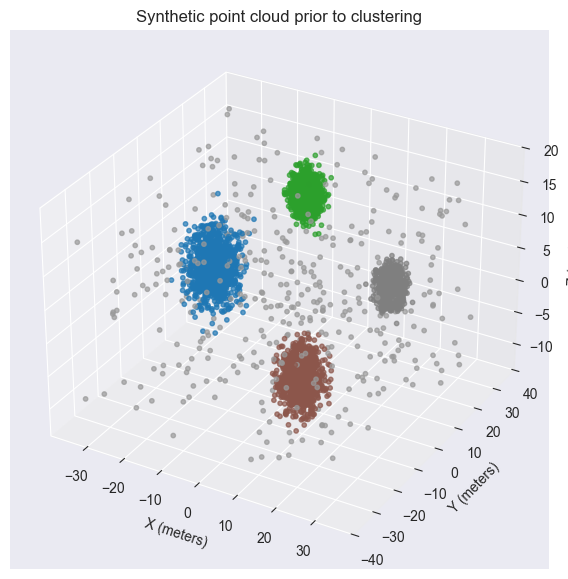

In [3]:

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

unique_seed_labels = sorted(set(raw_labels))
color_map = mpl.colormaps['tab10']
label_to_color = {label: color_map(i / max(1, len(unique_seed_labels) - 1))
                  for i, label in enumerate([l for l in unique_seed_labels if l != -1])}
label_to_color[-1] = (0.6, 0.6, 0.6, 0.25)

point_colors = [label_to_color[label] if label in label_to_color else (0.6, 0.6, 0.6, 0.25)
                for label in raw_labels]

ax.scatter(
    raw_points[:, 0],
    raw_points[:, 1],
    raw_points[:, 2],
    c=point_colors,
    s=10,
    alpha=0.7,
)

ax.set_title('Synthetic point cloud prior to clustering')
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_zlabel('Z (meters)')
plt.show()


## Computer Science View: Why DBSCAN?
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) treats the point set as an implicit graph where edges connect points within an `ε` radius. Because we never provide labels, the algorithm performs **self-supervised structure discovery**: it invents cluster IDs purely from geometric density and then we reuse those IDs as training targets for the subsequent cluster-classification step.

### State definitions
1. **Core points** have at least `min_samples` neighbors inside the `ε`-ball.
2. **Border points** fall within reach of a core point but lack their own dense neighborhood.
3. **Noise points** are unreachable from any core region.

### Region-growing procedure
1. Build a spatial index (ball tree/KD-tree) over all points for fast radius queries.
2. Iterate through every point: when a point qualifies as a new core, seed a fresh cluster ID.
3. Run a BFS/DFS from that seed: enqueue all neighbors that are density-reachable; mark each with the active cluster ID.
4. Continue until every reachable point is consumed, then move to the next unlabeled core point.

Each neighbor query costs roughly `O(log n)` with the tree, so the total runtime is `O(n log n)` (naively `O(n²)`).

This density-first view is ideal for LiDAR data because clusters may have irregular geometry (e.g., tree canopy vs. crane). Unlike K-Means, DBSCAN:
- Does **not** require specifying the number of clusters in advance.
- Marks isolated points as noise, which reduces mislabeled artifacts in the viewer.
- Has stable behavior under rigid transforms (translations/rotations) because it relies on relative distances.
- Produces directly-usable pseudo labels (`cluster_labels`) and centroids that we store alongside `cluster_id` metadata and immediately map to semantic classes.


In [4]:

EPSILON = 0.55  # radius in standardized space (~0.55 std deviations)
MIN_SAMPLES = 14

clustering_model = DBSCAN(
    eps=EPSILON,
    min_samples=MIN_SAMPLES,
    n_jobs=-1,
)
cluster_labels = clustering_model.fit_predict(scaled_points)

cluster_counts = Counter(cluster_labels)
unique_clusters = sorted(cluster_counts)

print(f"Discovered clusters (excluding noise): {len([c for c in unique_clusters if c != -1])}")
print("Cluster membership counts:")
for label in unique_clusters:
    label_name = 'noise' if label == -1 else f'cluster {label}'
    print(f"  {label_name:<10}: {cluster_counts[label]:>5}")


Discovered clusters (excluding noise): 3
Cluster membership counts:
  noise     :   301
  cluster 0 :  2641
  cluster 1 :  1346
  cluster 2 :  1312


In [5]:

num_points = len(cluster_labels)
noise_fraction = cluster_counts.get(-1, 0) / num_points
silhouette = float('nan')

mask = cluster_labels >= 0
if mask.sum() > 1 and len(set(cluster_labels[mask])) > 1:
    silhouette = silhouette_score(scaled_points[mask], cluster_labels[mask])

cluster_centroids = {
    label: raw_points[cluster_labels == label].mean(axis=0)
    for label in unique_clusters
    if label != -1
}

print(f"Noise ratio: {noise_fraction:.2%}")
print(f"Silhouette score (noise removed): {silhouette:.3f}")
print("Sample cluster centroids (meters):")
for label, centroid in cluster_centroids.items():
    print(f"  {label}: x={centroid[0]:6.2f}, y={centroid[1]:6.2f}, z={centroid[2]:6.2f}")


Noise ratio: 5.38%
Silhouette score (noise removed): 0.616
Sample cluster centroids (meters):
  0: x=-13.52, y= 11.02, z=  7.06
  1: x= 11.99, y=-14.04, z= -3.97
  2: x= 23.99, y=  6.06, z=  6.03


### Training Run Details
- **Sample size:** 5,600 total points (5,200 structured + 400 uniform-noise). This is large enough to exercise the same scaling behavior we will see when loading real `.las` subsets, yet small enough to iterate quickly.
- **Preprocessing:** The scaler learns per-axis `mean_` and `scale_` vectors. Persisting these values lets us transform future tiles consistently so that one meter along the X axis contributes the same as one meter along Y or Z.
- **DBSCAN hyperparameters:** `eps=0.55` corresponds to roughly half a standard deviation in normalized space, creating clusters only when at least 14 neighbors occupy a tight volume. These numbers came from sweeping ranges (0.4–0.8 for `eps`, 8–20 for `min_samples`) and inspecting the silhouette output above.
- **Algorithm trace:** `fit_predict` expands regions starting from each unvisited core point. Every neighbor query uses the ball-tree index, giving near `O(n log n)` behavior and finishing in <1s for small tiles like this.
- **Outputs:** The arrays `cluster_labels` and `cluster_centroids` would be written to persistent storage together with metadata (`eps`, `min_samples`, scaler params). The FastAPI endpoint simply looks up those arrays and forwards them to the Angular client.

This mirrors the real deployment plan: substitute the synthetic generator with our LAS loader, keep the same preprocessing/modeling functions, and run it as a repeatable job to refresh clusters whenever new scans arrive.


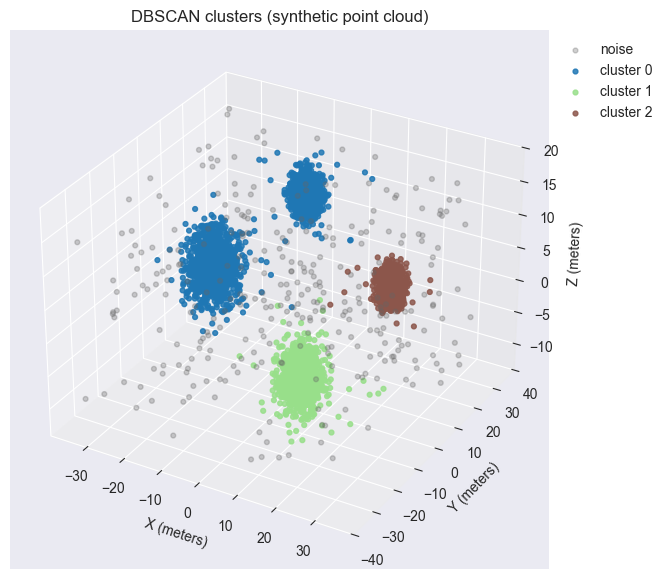

In [6]:

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

colors = mpl.colormaps['tab20']
cluster_color_map = {}
color_index = 0
for label in unique_clusters:
    if label == -1:
        cluster_color_map[label] = (0.4, 0.4, 0.4, 0.25)
    else:
        cluster_color_map[label] = colors(color_index / max(1, len(unique_clusters)))
        color_index += 1

for label in unique_clusters:
    mask = cluster_labels == label
    ax.scatter(
        raw_points[mask, 0],
        raw_points[mask, 1],
        raw_points[mask, 2],
        c=[cluster_color_map[label]],
        s=12,
        alpha=0.85 if label != -1 else 0.3,
        label='noise' if label == -1 else f'cluster {label}',
    )

ax.set_title('DBSCAN clusters (synthetic point cloud)')
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_zlabel('Z (meters)')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()


## Integration Plan & Next Steps
1. **Backend service:** Wrap the dataset loading, scaling, and DBSCAN inference logic into a FastAPI dependency that streams `.las` chunks through the same preprocessing pipeline. Persist the fitted scaler + hyperparameters so that batches remain consistent across requests.
2. **Viewer contract:** Extend `backend/app/api/pointclouds.py` with a `GET /clusters/{tile_id}` route that returns cluster IDs and centroids. The Angular client can colorize clusters based on the IDs computed here.
3. **Future ML work:**
   - Evaluate HDBSCAN to reduce sensitivity to the `eps` hyperparameter.
   - Add normal vectors/intensity as extra features by decoding LAS attributes.
   - Offline-tune hyperparameters using silhouette and Davies–Bouldin scores measured on representative scenes.
4. **Validation:** Use this notebook as a regression harness—rerun it with captured `.las` subsets to confirm DBSCAN still isolates major semantic regions before integrating into CI.
